# AMPEL intro III: Using a T2 unit to calculate transient properties

Here is an example of how to implement a T2 unit and run it in a standalone mode, without the need to have the whole AMPEL system and its services running. It is intended to be examined after the `t0_unit_example` notebook.

T2 units derive further information regarding an individual transient based on either information provided in alert(s) or through external queries (e.g. catalogs).

## T2 Unit Implementation

First, we need to implement a T2 unit class. This class should inherit from the class `AbsT2Unit` and implement a constructor and a `run` method.

The implementation of this class can be seen here: https://github.com/AmpelProject/Ampel-contrib-sample/blob/master/ampel/contrib/groupname/t2/T2ExamplePolyFit.py

Then, we initialize an object from this class, giving as a parameter a standard Python logger object.

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

from ampel.contrib.groupname.t2.T2ExamplePolyFit import T2ExamplePolyFit
myt2 = T2ExamplePolyFit(logger=logger)

Then, we download from the web a compressed TAR file with alerts over which we can run our T2 unit:

In [2]:
import os
import urllib.request

small_test_tar_url = 'https://ztf.uw.edu/alerts/public/ztf_public_20181129.tar.gz'
small_test_tar_path = 'ztf_public_20181129.tar.gz'

if not os.path.isfile(small_test_tar_path):
    print('Downloading tar')
    urllib.request.urlretrieve(small_test_tar_url, small_test_tar_path)

Afterwards, we need to load these alerts (which have an AVRO extension) and transform them into `AmpelAlert` objects. We can achieve that with the help of the `load_from_tar` method of the `DevAlertLoader` module. For the sake of this example we will only run our T2 unit over the first alert from the set:

In [3]:
from ampel.ztf.pipeline.t0.load.DevAlertLoader import load_from_tar

alert_list = load_from_tar(small_test_tar_path)
alert = alert_list[0]
print(alert)

Then, we proceed to transform the selected `AmpelAlert` into a lightcurve object by using the `ZIAlertUtils._create_lc` object. Over this lightcurve object we can now run our T2 unit using some parameters, in this case the degree of the polynomial fit. This returns a dictionary of results that will, when run inside an Ampel instance, be stored in the transient database:

In [4]:
from ampel.ztf.utils.ZIAlertUtils import ZIAlertUtils

lc = ZIAlertUtils._create_lc(alert.pps, alert.uls)

run_config = {
    "degree" : 5
}

out = myt2.run(lc, run_config)
out

/Users/jakob/Documents/ZTF/Ampel/ampel-contrib-sample/ampel/contrib/groupname/t2/T2ExamplePolyFit.py:61: RankWarning: Polyfit may be poorly conditioned
  p = numpy.polyfit(x, y, run_config['degree'])


{'chi2': 0.6192213326648925,
 'polyfit': [-1.0961359302623197e-22,
  5.3896394214184006e-17,
  5.299994683346074e-10,
  0.001302956758609511,
  800.7822706007479,
  -9843709523.291702]}

Finally, we can plot the result of the processing of our T2 unit, in this case a polynomial fit over the lightcurve, by using the standard Python Matplotlib library:

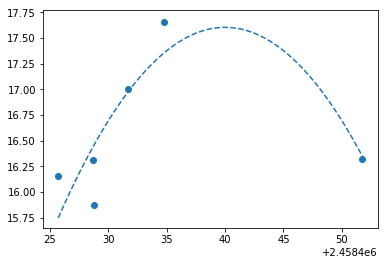

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

obs_date = sorted(lc.get_values('obs_date'))
mag = sorted(lc.get_values('mag'))

fit = np.poly1d(out['polyfit'])

ax = plt.axes()
ax.scatter(*zip(*lc.get_tuples('obs_date', 'mag')))
x_range = np.linspace(obs_date[0], obs_date[-1], 100)
ax.plot(x_range, fit(x_range), '--')